In [5]:
import cv2
import numpy as np
import os
import glob
import peakutils # Buscar implementación en C+

import matplotlib
import matplotlib.pyplot as plt

Clases de archivos de test:
* Imágenes mal clasificadas en la última corrida: {1,2,7,8,9,10,11,14,17,20,21,22,26,29,30,31,32}
* Imágenes que contienen lagunas de maleza: {1,2,

* ¿Se debería centrar solo en los cuadrantes internos a las rectas detectadas y descartar las exteriores? Ya que siempre dan problemas por la perspectiva

Problemas:
* Detección de lagunas de maleza
* Ángulos no posibles en rectas
* Agregar sentencias de control para descartar imágenes con detección erronea (rectas que se intersecan en la imagen)
* ¿Es necesario agregar ancho al cultivo? Si se toman ancho de cultivo mayores no debería ser necesario esto.

Algunas de las imágenes mal clasificadas se deben descartar.<br>
Para la próxima hay que guardar la información de ángulo de toma, ancho de cultivo y altura. Se debe armar un esqueleto que permita mantener estos durante la toma.<br>

La imagen 2 presenta una laguna pero de cultivo. Presenta maleza en el lado derecho pero esta laguna da problemas para detectar rectas con Houghs, una posibilidad es cortar la imagen ya que se encuentra a la derecha, para generalizar, se cortaría el lado (izquierdo o derecho) que presente una laguna, si el otro lado no presenta lagunas se analiza, sino se declara toda la imagen con presencia de maleza.<br>

En la imagen 1 se cruzan las curvas debido a que hay mucha vegetación mezclada de un lado, los microROIs se entre cruzan de surco.<br>

En la imagen 4 no detecta cierta maleza, requiere ajustes (posiblemente en el porcentaje para clasificar como maleza)<br>



## Funciones varias de soporte

In [6]:
# Para mostrar una imagen
def mostrar_img(lbl, img, reduction_ratio=0):
    mostrar_imgs([lbl],[img], reduction_ratio)

# Para mostrar varias imágenes
def mostrar_imgs(lbls, vec_img, reduction_ratio=0):
    if ((reduction_ratio >= 1) or (reduction_ratio < 0)):
        reduction_ratio = 0
    for i in range(len(vec_img)):
        h = vec_img[i].shape[0]
        h = (int)(h - (h*reduction_ratio))
        w = vec_img[i].shape[1]
        w = (int)(w - (w*reduction_ratio))
        img_rs = cv2.resize(vec_img[i], (w, h))
        cv2.imshow(lbls[i], img_rs)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
###Para escalar la imagen de 0 a max_value
def scaling(img, max_value):
    amax = np.amax(img)
    amin = np.amin(img)
    scalingIndex = max_value/(amax-amin)
    img = ((img-amin)*scalingIndex)
    img = img.astype(np.uint8)
    return img

### Devuelve el porcentaje de vegetación que hay en la imágen (255 es vegetación)
def get_total_vegetation(binary_img):
    return (np.sum(binary_img == 255) / (binary_img.shape[0] * binary_img.shape[1]))

### Busca los puntos máximos de una distribución (Buscar librerías en C++)
def get_maximum_points(img, winSize):
    #Generación de histograma
    histogram = column_histogram(img)
    #Suavizado de histograma
    min_dist = int(winSize/2)
    winMidSize = int(min_dist/2)
    smoothed = np.zeros(histogram.shape, np.int16)
    for i in range(0, len(histogram)):
        total = 0
        for j in range(0, min_dist):
            tmp = i - winMidSize + j
            if (tmp >= 0 and  tmp < len(histogram)):
                total += histogram[tmp]
        smoothed[i] = int(total/min_dist)
    #Detección de máximos locales
    indexes = []
    min_dist = winSize*1.4
    meceta_counter = 0
    local_maximas = 0
    last_max_dist = 0
    i=0
    while(i<len(histogram)):
        if(local_maximas == 0 and smoothed[i]>0):
            indexes.append(i)
#             print('agregado: ' + str(i))
            local_maximas += 1
            last_max_dist=0
        else:
            if(local_maximas!=0 and smoothed[i]>0):
#                 if(indexes[local_maximas-1]>480):
#                   2, 94, 1, 12
#                     print(str(local_maximas) + ', ' + str(i) + ', ' + str(last_max_dist) + ', ' + str(meceta_counter))
                if(smoothed[i]>smoothed[indexes[local_maximas-1]]): #Es mayor
                    if(last_max_dist<=min_dist):
                        indexes[local_maximas-1]=i
                        last_max_dist=0
                    else:
                        indexes.append(i)
#                         print('agregado: ' + str(i))
                        local_maximas += 1
                        last_max_dist=0
                else:
                    if(smoothed[i]<smoothed[indexes[local_maximas-1]]):
                        if(smoothed[i]>smoothed[i-1] and last_max_dist>min_dist):
                            indexes.append(i)
#                             print('agregado: ' + str(i))
                            local_maximas += 1
                            last_max_dist=0
                    else:
                        if(smoothed[i]==smoothed[indexes[local_maximas-1]] and i==indexes[local_maximas-1]+1):
                            meceta_counter=0
                            while(i<len(histogram)-1 and smoothed[i]==smoothed[indexes[local_maximas-1]]):
                                i+=1
                                meceta_counter+=1
                                last_max_dist+=1
                            if(smoothed[i]<smoothed[i-1]):
                                _tmp = indexes[local_maximas-1]+int(meceta_counter/2)
                                if (_tmp-indexes[local_maximas-1]>min_dist):
                                    indexes.append(_tmp)
#                                     print('agregado: ' + str(_tmp))
                                    local_maximas+=1
                                    last_max_dist=0
                                
        i+=1
        last_max_dist+=1

    #Gráfica
    indexes = np.array(indexes, np.int16)
    #------------------------#
    if (debugging):
        x = np.arange(0, img.shape[1], 1)
        fig, ax = plt.subplots()
        ax.plot(x, smoothed)
        ax.scatter(indexes, smoothed[indexes], c='blue')
        ax.grid()
        plt.show()
    if(store):
        fig.savefig('maximos.png')
    #------------------------#
    return indexes

# Devuelve 1 si la posición enviada pertenece al cultivo, -1 si pertenece a la maleza
def is_crop_or_furrow_lineal(lines, available, p0, crop_width):
    # Crop: 1, Crop furrow: -1, None: 0¿
    if (len(lines) != 0):
        x, y = p0
        h_buffer = {}
        h_buffer[0] = lines[0].get_y(x)
        most_left = h_buffer[0] - crop_width
        most_right = h_buffer[0] + crop_width
        for line_index in range(1, len(lines)):
            h_buffer[line_index] = lines[line_index].get_y(x)
            most_left = min(most_left, h_buffer[line_index] - crop_width)
            most_right = max(most_right, h_buffer[line_index] + crop_width)
        if (y <= most_left or y >= most_right): #Caso a izquierda de primera linea o a derecha de última línea
                return 0
        for key in h_buffer.keys():  # Paso por cada curva
            c_left = h_buffer[key] - crop_width
            c_right = h_buffer[key] + crop_width
            if (y <= c_right and y >= c_left): #Si está dentro de alguna franja de cultivo, es surco
                return 1
        return -1 #Si no es ninguno de los otros, el entre surco
    else:
        return 0

# Escalar los valores para que no tenga overflow, ver como modifican los escalares
def least_squares_line(x_list, y_list):
    # Calcular el centroide en vez de usar point0
    xc, yc = np.sum(x_list)/len(x_list), np.sum(y_list)/len(y_list)
    x_list, y_list = np.array(x_list, np.uint32), np.array(y_list, np.uint32)
    sum_x, sum_y = np.sum(x_list), np.sum(y_list)
    sum_xy = np.sum(np.multiply(x_list, y_list))
    sum_x_squared = np.sum(np.multiply(x_list, x_list))
    numerator = x_list.shape[0] * sum_xy - (sum_x * sum_y)
    denominator = x_list.shape[0] * sum_x_squared - (sum_x * sum_x)
    # Si 0 es denominador, es una recta vertical, la pendiente es infinito
    m = numerator / denominator# if denominator != 0 else 999 
    b = int(yc - m * xc)
    return m, b  # Coeficientes: Lineal y independiente

### Promedio de una lista de valores
def mean(values_list):
    values_list = np.array(values_list, np.uint64)
    return (np.sum(values_list) / values_list.shape[0])

class Line:
    #Si la pendiente es mayor a 80, se toma como recta vertical y se debe usar x_offset
    def __init__(self, m, b):
        self.m = m
        self.b = b
        self.white_amount = -1

     # Devuelve la cantidad de vegetación (255) que hay en una recta
    def set_white_amount(self, img):
        sum = 0
        for i in range(0, img.shape[0]):
            h = self.get_y(i)
            if (h >= 0 and h < img.shape[1]):
                if (img[i, h] > 0):
                    sum = sum + 1
        self.white_amount = sum
        
    def __str__(self):
        return 'm: ' + str(self.m) + ' - b: ' + str(self.b) + ' - x_offset: ' + str(self.x_offset) + ' - white amount: ' + str(self.white_amount)
    
    # Devuelve el valor de x en una recta, dada su altura (y), si la pendiente es muy pronunciada, se toma como recta vertical
    def get_y(self, x):
        return int(x*self.m+self.b)
    
    def __copy__(self):
        return Line(self.m, self.b)

class MicroROI:
    def __init__(self, microimg, h_offset, v_offset, possible_centroid):
        vert_sum, horiz_sum, _sum = 0, 0, 0
        vc, hc = possible_centroid
        for h in range(0, microimg.shape[1]):
            for v in range(0, microimg.shape[0]):
                if (microimg[v, h] > 0):  # Cambiar a binario
                    vert_sum, horiz_sum, _sum = vert_sum + v, horiz_sum + h, _sum + 1
        if (_sum != 0):
            vc, hc = int(vert_sum / _sum)+v_offset, int(horiz_sum / _sum)+h_offset
        self.vc, self.hc = vc, hc
        
    def get_centroid(self):
        return self.vc, self.hc

### Devuelve la imágen con el índice seleccionado aplicado
def img_to_color_index(img, index):
    if (index == 'cive'):
        return get_CIVE(img)
    elif (index == 'exg'):
        return get_ExG(img)
    else:
        return img

def get_normalized(img):
    img = img.astype(np.uint16)
    denominator = img[:, :, 0] + img[:, :, 1] + img[:, :, 2]
    # Max 255+255+255, Min 1
    denominator = np.where(denominator == 0, 1, denominator)
    return cv2.merge((img[:, :, 0]/denominator, img[:, :, 1]/denominator, img[:, :, 2]/denominator))

def get_CIVE(img):
    img_norm = get_normalized(img)
    return 0.441*img_norm[:, :, 0]-0.811*img_norm[:, :, 1]+0.385*img_norm[:, :, 2]+18.78745

def get_ExG(img):
    r, g, b = cv2.split(img)
    r_mx = np.amax(r)
    g_mx = np.amax(g)
    b_mx = np.amax(b)
    if (r_mx == 0):
        r_mx = 1
    if (g_mx == 0):
        g_mx = 1
    if (b_mx == 0):
        b_mx = 1
    r = r / r_mx
    g = g / g_mx
    b = b / b_mx
    denominator = r + g + b
    denominator = np.where(denominator == 0, 1, denominator)
    r = r / denominator
    g = g / denominator
    b = b / denominator
    return 2*g-r-b

### Devuelve el histograma de columnas (para imágenes de 8 bits de profundidad, 255 = blanco)
def column_histogram(img_in):
    vector = np.zeros(img_in.shape[1], np.uint16)
    for col in range(0, img_in.shape[1]):
        vector[col] = np.sum(img_in[:, col] > 0)
    return vector

# Para realizar un corte en el margen superior de la imagen
def v_crop_top(img, crop_ratio):
    if (crop_ratio < 0 or crop_ratio > 1):
        crop_ratio = 0
    h2 = img.shape[0]
    h1 = (int)(h2*crop_ratio)
    w = img.shape[1]
    return img[h1:h2, 0:w]

##### Cambios
* Corroborar que todas las variables se utilizan, declaran, etc.
* Verificar que es mejor, least absolute deviation o least squares
* Hacer la clase punto para la lista de coordenadas de los centroides
* Conseguir los algortimos que utilizan librerías, buscar soluciones sencillas con mismos resultados

## Variables de configuración

In [7]:
# Reducción del tamaño original para poder ver las imágenes en tamañas chicas
reduction_to_see = -0.8

# Kernels para utilizar
kernel_ones = np.ones((3, 3), np.uint8)
kernel_plus = np.array([[0,1,0],
                        [1,1,1],
                        [0,1,0]], np.uint8)
kernel_verticales = np.array([[1, 0, -1],  # Segmentos verticales
                             [2, 0, -2],
                             [1, 0, -1]])
kernel_vertical = np.array([
    [0, 1, 0],
    [0, 1, 0],
    [0, 1, 0],
], np.uint8)

debugging = True
# debugging = False
store = False
store = True
                                        #-------DEPENDIENTES-------#
#-------Depende del ángulo de cámara-------#
# Cuanto se corta de la imagen para quitar el punto de fuga
porcentaje_de_crop = 0

#-------Depende del tipo de planta y su estadio-------#
# Ancho de línea de cultivo en píxeles
crop_width_bottom = 35
crop_width_top = 10
# Este porcentaje de ancho es dependiente del tipo de cultivo y el estadío en el que se encuentra
addition_percentage = 0.6
# addition = crop_width_bottom * addition_percentage

#-------Depende de la luminosidad-------#
# Índices posibles: cive exg (cive para nublado, exg para soleado)
indice_seleccionado = 'exg'

                                        #-------VERIFICABLES-------#
# Para Hough
# Rho: Resolución de distancia para el acumulador de píxeles
in_rho = 18
# Theta: Resolución de ángulos para el acumulador de radianes
in_theta = np.pi/180
# Threshold: Parametro de threshold para el acumulador, pasan las líneas con mayor cantidad de votos
in_threshold = 100
# Ángulos de control configurables 
# CORREGIR
ang_max_tercio_1 = 0.49
ang_min_tercio_1 = 0.2
ang_max_tercio_2 = 2.92
ang_min_tercio_2 = 2.65
ang_max_tercio_3 = 0.39
ang_min_tercio_3 = 2.75

                                        #-------AJUSTABLES-------#
# Un cuarto de la imagen original
rs_ratio = 0.25
# Porcentaje mínimo requerido para aplicar erosión y resaltar los surcos
porcentaje_para_erosion = 0.15
#Porcentaje de maleza mínimo que tiene que tener un cuadrante para detectarlo con maleza
weed_porc = 0.002

## Algoritmo

### Detección

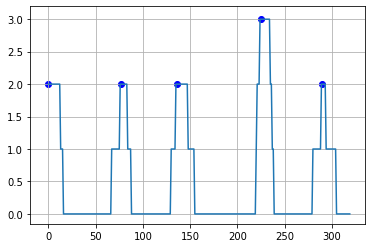

Los valores de las bases detectados son: [  0  77 136 225 290]
La cantidad de detecciones por Hough son: 115
El tamaño de la matriz de centroides es: (4, 12)
line: 0 m: 0.3802937038899533
line: 1 m: -0.028684112927299207
line: 2 m: 0.7060224101234793
line: 3 m: -0.3316935868572773
cw: 16.000000000000142 - cwt: 16 - 
4


In [8]:
# %%timeit -n 10 -r 10
# 1.57 s ± 89.3 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)
for i in range(10, 11):
# for i in range(1, 33):
    path_to_imgs = 'img/test/originals_rs_2/'
    file_name = 'test' + str(i) + '_rs'
#     print('El nombre del archivo cargado es: ' + file_name)
    _original = cv2.imread(path_to_imgs + file_name + '.png', cv2.IMREAD_COLOR)
    if _original is None:
        print('Warning: imagen no cargada')
    else:

        #-------PREPARACIÓN DE DATOS-------#

        # Cortar la parte superior de la imagen (esto se calcula de manera manual, depende del ángulo de pitch que tenga la cámara)
        # Módulo IP de control que pérmite el paso de los píxeles por debajo
        original = v_crop_top(_original, porcentaje_de_crop)

        #------------------------#
        if (debugging):
            mostrar_img('cropped', original)
        #------------------------#

        # Obtención de imagen con índice
        # Para módulo IP - Debe devolver índice en 8 bits
        resized = cv2.resize(original, None, fx=rs_ratio,
                             fy=rs_ratio, interpolation=cv2.INTER_AREA)
        
        # Se utilizan los índice CIVE y ExG (Siendo el índice CIVE eficiente para días parcial y totalmente nublados, y el índice ExG para días soleados)
        img_veg = img_to_color_index(resized, indice_seleccionado)
        
        # La convierto en binario de 8 bits para aplicar Otsu (No debe ser parte del VHDL, ya debe devolver 8 bits)
        img_veg = scaling(img_veg, 255)
        # La parte de inversión de valor debe estar dentro del calculo del índice
        if (indice_seleccionado == 'exg'):
            img_veg = cv2.bitwise_not(img_veg)
            
        #------------------------#
        if (debugging):
            mostrar_img('indice', img_veg)
        if(store):
            cv2.imwrite(path_to_imgs + file_name + '_' + 'indice' + '.png', img_veg)
        #------------------------#

#         cv2.imwrite(path_to_imgs + file_name + '_' +
#                         'veg' + '.png', img_veg)
        # Utilizar el algoritmo con un reescalado de la imagen (Se debe poder configurar el tamaño de reducción y el algortimo utilizado)
        
        # Otsu (Comienza parte pesada de algoritmo, a partir de acá debe ir en un mismo módulo IP)
        ret, segmented = cv2.threshold(
            img_veg, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
        new_height = img_veg.shape[0]
        new_width = img_veg.shape[1]
        
        #Erosión vertical para destacar las rectas
        img_veg = cv2.erode(segmented, kernel_vertical)
        
#         cv2.imwrite(path_to_imgs + file_name + '_' + 'segmentado' + '.png', img_veg)

        # Utilizo eroción para acentuar la diferencia entre líneas de cultivo, cuando la cantidad de vegetación es alta
        if (get_total_vegetation(img_veg) > porcentaje_para_erosion):
            img_veg_eroded = (cv2.erode(img_veg, kernel_plus))
        else:
            img_veg_eroded = img_veg.copy()

        # ---------------------- Para implementar
        # Si se detectan lagunas de vegetación (tiene que ver con el ancho de los cultivos según 
        # la distancia en la imágen) se debe marcar como zona con maleza, y el resto "limpio",
        # ya que el algoritmo para detección de las rectas no va a funcionar si siguieramos

        #------------------------#
        if (debugging):
            mostrar_imgs(['segmented', 'img_veg', 'img_veg_eroded'],
                         [segmented, img_veg, img_veg_eroded], reduction_to_see)
        if(store):
            cv2.imwrite(path_to_imgs + file_name + '_' + 'segmentado' + '.png', segmented)
            cv2.imwrite(path_to_imgs + file_name + '_' + 'erosion1' + '.png', img_veg)
            cv2.imwrite(path_to_imgs + file_name + '_' + 'erosion_condicional' + '.png', img_veg_eroded)
        #------------------------#

        #-------HISTOGRAMA-------#
        # Calcular histograma de la franja inferior de la imágen, detectar la cantidad de picos según la cantidad de lineas se busquen, si hay más o menos de lo buscado se debe descartar la imagen.
        h_space = int(new_height/8)
        indexes = get_maximum_points(img_veg_eroded[(new_height - h_space):new_height, 0:new_width], crop_width_bottom)

        #------------------------#
        if (debugging):
            print('Los valores de las bases detectados son: ' + str(indexes))
        if (store):
            cv2.imwrite(path_to_imgs + file_name + '_' + '12th' + '.png', img_veg_eroded[(new_height - h_space):new_height, 0:new_width])
        #------------------------#
        
        #-------TRANSFORMADA DE HOUGH-------#
        middle = new_height-int(new_height/2)
        bottom_image = img_veg_eroded[middle:new_height,
                                      0:new_width]
        
         #------------------------#
        if (store):
            cv2.imwrite(path_to_imgs + file_name + '_' + 'bottom' + '.png', bottom_image)
        #------------------------#
        
        # Calculo líneas de la TH (requiere edge detection previo, ver cual ocupa menos de los métodos)
        edges = cv2.filter2D(bottom_image, -1, kernel_verticales)
        
        #------------------------#
        if (store):
            cv2.imwrite(path_to_imgs + file_name + '_' + 'bordes' + '.png', edges)
        #------------------------#
        
        # Hough propiamente dicho
        lines = cv2.HoughLines(edges, in_rho, in_theta, in_threshold)        
        lines_2=lines
        # Control de las líneas detectadas
        third_1 = (int)(bottom_image.shape[1]/3)
        third_2 = (int)(bottom_image.shape[1]*(2/3))
        delta = int(crop_width_bottom/2)  # Medio ancho de surco para control
        upper_limit = indexes + delta
        lower_limit = indexes - delta
        # La cantidad de grupos es dinámico, en c++ tendrá que ser estático con un tope, cada elemento del grupo tiene: m, b y cantidad de vegetación (la clase Line)
        groups_tmp = {}
        if type(lines) is np.ndarray:
            for line in lines:
                for rho, theta in line:
                    if (np.cos(theta) != 0):
                        m = -(np.sin(theta)/np.cos(theta))
                        b = rho/np.cos(theta)
                        y = int(bottom_image.shape[0]*m+b)
                        group = -1
                        for i in range(0, len(indexes)):
                            if (y <= upper_limit[i] and y >= lower_limit[i]):
                                group = i
                        # Ángulos de control configurables
                        correct_angle_and_position = (y < third_1 and theta < ang_max_tercio_1 and theta > ang_min_tercio_1) \
                            or (y > third_2 and theta < ang_max_tercio_2 and theta > ang_min_tercio_2) \
                            or (y > third_1 and y < third_2 and (theta < ang_max_tercio_3 or theta > ang_min_tercio_3))
                        if (y > 0 and y < bottom_image.shape[1] and group != -1 and correct_angle_and_position):
                            if group not in groups_tmp.keys():
                                groups_tmp[group] = Line(m,b)
                                groups_tmp[group].set_white_amount(bottom_image)
                            else:
                                line = Line(m,b)
                                line.set_white_amount(bottom_image)
                                if (groups_tmp[group].white_amount < line.white_amount):
                                    groups_tmp[group] = line

        groups = {}
        i = 0
        for key in groups_tmp.keys():
            groups[i] = groups_tmp[key]
            i += 1
        
        #------------------------#
        if (debugging):
            print('La cantidad de detecciones por Hough son: ' + str(len(lines)))
            with_lines = cv2.merge((bottom_image, bottom_image, bottom_image))
            for key in groups.keys():
                line = groups.get(key)
                m = line.m
                b = line.b
                x0 = 0
                y0 = int(x0*m+b)
                x1 = with_lines.shape[0]
                y1 = int(x1*m+b)
                cv2.line(with_lines, (y0, x0), (y1, x1), (0, 255, 0), 2)
            mostrar_img('Hough', with_lines)
        if(store):
            cv2.imwrite(path_to_imgs + file_name + '_' + 'hough' + '.png', with_lines)
        #------------------------#
        
        #-------SEGMENTACIÓN-------#
        # Segmentación de la imagen en partes que disminuyen un 5% cuando se avanza hacia arriba
        # La segmentación es dependiente del alto de la imagen, ya que siempre se calculan 12, por tanto se puede realizar una vez cuando cambia el
        # valor de corte, de proporción de disminución y de cambio en resolución
        # Puede utilizarse un módulo IP aparte para que lo calcule, hay que calcular el alto de la en base a los parametros de la imagen
# -------------------- ESTATICO
        # Para obtener los 4 segmentos inferiores
        x_segments_bottom = np.arange(11, 15)
        x_segments_top = np.arange(0, 9)

        # Para obtener los 8 segmentos superiores
        x_segments_bottom = (np.multiply((np.true_divide(
            x_segments_bottom, np.sum(x_segments_bottom))), middle)).astype(np.uint16)
        x_segments_top = (np.multiply((np.true_divide(
            x_segments_top, np.sum(x_segments_top))), middle)).astype(np.uint16)
        x_segments_bottom = x_segments_bottom[::-1]
        x_segments_top = x_segments_top[::-1]
        x_segments_bottom[0] = x_segments_bottom[0] + \
            middle - np.sum(x_segments_bottom)
        x_segments_top[0] = x_segments_top[0] + middle - np.sum(x_segments_top)
        
        #Se obtienen los 12 segmentos uniendo los 4 inferiores y los 8 superiores
        x_segments = np.concatenate((x_segments_bottom[0:len(
            x_segments_bottom) - 1], x_segments_top[0:len(x_segments_top)]))
        for i in range(len(x_segments) - 2, -1, -1):
            x_segments[i] = x_segments[i] + x_segments[i+1]
        x_segments = np.concatenate(([new_height], x_segments))
        
        #------------------------#
        if (debugging):
            with_lines = cv2.merge((img_veg_eroded, img_veg_eroded, img_veg_eroded))
            for x in x_segments:
                if x > 0:
                    if (x >= middle):
                        cv2.line(with_lines, (0, x),
                                 (with_lines.shape[1], x), (255, 0, 0), 1)
                    else:
                        cv2.line(with_lines, (0, x),
                                 (with_lines.shape[1], x), (0, 255, 0), 1)
            mostrar_img('Divisions', with_lines)
        #------------------------#

        #-------CÁLCULO DE MICROROIS-------#
        # Se calcula el centro del ROI en base a las rectas encontradas por TH
        # Si el microROI no tiene píxeles blancos se asume que el centro es el centroide
        # ---------------------- Para implementar
        # Tres vacios consecutivos en una línea es el tope, sino se descarta la imagen
        
        # Matrices de puntos (puede ser una clase) depende de la cantidad de rectas (cantidad dinámica, en HLS se debe poner un tope)
        x_centroids_matrix = np.zeros(
            (len(groups), len(x_segments) - 1), np.uint16)
        y_centroids_matrix = np.zeros(
            (len(groups), len(x_segments) - 1), np.uint16)
# -------------------- ESTATICO
        crop_width = crop_width_bottom
        crop_width_decay_seg = (crop_width_bottom - crop_width_top) /  (len(x_segments) - 1)  # (inicial-final)/pasos
        
        # Ya que la recta está calculada para la parte inferior, es necesario un offset de b para transladarla
        img_offset = middle
        for key in groups.keys():
            line = groups.get(key)
            line.b = line.get_y(-middle)
            
        #------------------------#
        if (debugging): #Se crea la imagen para posterior muestra en debugging
            with_lines = img_veg_eroded.copy()
            with_lines = cv2.merge((with_lines, with_lines, with_lines))
            print('El tamaño de la matriz de centroides es: ' + str(x_centroids_matrix.shape))
        #------------------------#
        
        # Contador del segmento en el que se posiciona, los valores son: [1, ..., 12]
        segment_index = 1
        while x_segments[segment_index] >= middle:
            for key in groups.keys():
                # Obtener cada descriptor de línea
                line = groups.get(key)
                x1, x2 = x_segments[segment_index - 1], x_segments[segment_index]  # Inferior, superior
                x_middle=(x1-x2)/2+x2
                # El x del inferior, respecto a la recta
                y_temp = line.get_y(x1)
                y_possible=line.get_y(x_middle)
                # Desplazamientos según ancho de línea
                y1, y2 = y_temp - int(crop_width/2), y_temp + int(crop_width/2)
                if (y1 < 0): y1 = 0
                if (y2 >= new_width): y2 = new_width-1
                # Pasarle microimagen con desplazamiento en x e y
                centroid = MicroROI(img_veg_eroded[x2:x1, y1:y2], y1, x2, (x_middle, y_possible))
                x_centroids_matrix[key, segment_index - 1], y_centroids_matrix[key,segment_index - 1] = centroid.get_centroid()
                #------------------------#
                if (debugging):
                    cv2.line(with_lines, (y1, x1), (y1, x2), (255, 255, 0), 1)
                    cv2.line(with_lines, (y2, x1), (y2, x2), (255, 255, 0), 1)
                    cv2.circle(with_lines, (y_centroids_matrix[key, segment_index - 1], x_centroids_matrix[key, segment_index - 1]), 3, (255, 0, 255), 2)
                #------------------------#
#                 key = key + 1  # Próxima línea
            # Nuevo ancho de microROI
            crop_width = crop_width - crop_width_decay_seg
            segment_index = segment_index + 1  # Próxima franja

        #------------------------#
        if (debugging):
            mostrar_img('Centroides hasta la mitad', with_lines)
        if(store):
            cv2.imwrite(path_to_imgs + file_name + '_' + 'centroides_p' + '.png', with_lines)
        #------------------------#
            
        # Usar la recta con los últimos cuatro elementos para el ROI del siguiente nivel
        # Calcula centroides del siguiente nivel y agregarlos en las matrices correspondientes
        last_centroids_index = 0
        while segment_index < (len(x_segments)):
            # Para cada línea
            for quadrant_index in range(0, x_centroids_matrix.shape[0]):
                # Tomo elementos de [i, i+3] correspondientes a los últimos cuatro centroides
                x_list = x_centroids_matrix[quadrant_index,last_centroids_index:last_centroids_index + 4]
                y_list = y_centroids_matrix[quadrant_index,last_centroids_index:last_centroids_index + 4]
#                 last_centroid = (y_list[-1],x_list[-1])
                m, b = least_squares_line(x_list, y_list)#, last_centroid)
#                 m, b = least_squares_line(x_list, y_list)
                line = Line(m,b)
                x1, x2 = x_segments[segment_index - 1], x_segments[segment_index]  # Inferior, superior
                x_middle=(x1-x2)/2+x2
                y_temp = line.get_y(x1)
                y_possible=line.get_y(x_middle)
                # Desplazamientos según ancho de línea
                y1, y2 = y_temp - int(crop_width / 2), y_temp + int(crop_width / 2)
                # Pasarle microimagen con desplazamiento en x e y
                centroid = MicroROI(img_veg_eroded[x2:x1, y1:y2], y1, x2, (x_middle, y_possible))
                x_centroids_matrix[quadrant_index, segment_index-1], y_centroids_matrix[quadrant_index, segment_index-1] = centroid.get_centroid()

                #------------------------#
                if (debugging):
                    cv2.line(with_lines, (y1, x1), (y1, x2), (255, 255, 0), 1)
                    cv2.line(with_lines, (y2, x1), (y2, x2), (255, 255, 0), 1)
                    cv2.circle(with_lines, (y_centroids_matrix[quadrant_index, segment_index-1], x_centroids_matrix[quadrant_index, segment_index-1]), 3, (255, 0, 255), 2)
                #------------------------#
    
            segment_index = segment_index + 1  # Próxima franja
            crop_width = crop_width - crop_width_decay_seg
            last_centroids_index = last_centroids_index + 1
        
        #------------------------#
        if (debugging):
            mostrar_img('Centroides', with_lines)
        if(store):
            cv2.imwrite(path_to_imgs + file_name + '_' + 'centroides_t' + '.png', with_lines)
        #------------------------#
        
        #------MÉTODO DE MÍNIMOS CUADRADOS-------#
        # Una vez obtenidos todos los centroides de cada línea se realiza una análisis de regresión
        
        #La cantidad de columnas depende de la cantidad de surcos
        lines = {}
        available = np.empty(x_centroids_matrix.shape[0], np.bool)
        
        #------------------------#
        if (debugging):
            with_lines = img_veg_eroded.copy()
            with_lines = cv2.merge((with_lines, with_lines, with_lines))
        #------------------------#
        
        # Para cada línea
        for quadrant_index in range(0, x_centroids_matrix.shape[0]):
            x_list = x_centroids_matrix[quadrant_index,0:x_centroids_matrix.shape[1]]
            y_list = y_centroids_matrix[quadrant_index,0:y_centroids_matrix.shape[1]]
#             last_centroid = (y_list[-1], x_list[-1])
            m, b = least_squares_line(x_list, y_list)#, last_centroid)
            line = Line(m,b)
            lines[quadrant_index] = line
            y_temp=line.get_y(new_height)
            if ((y_temp <= third_1 and m < -0.15 and m > -1) or (y_temp >= third_2 and m > 0.15 and m < 1) \
                    or (y_temp > third_1 and y_temp < third_2 and m < 0.4 and m > -0.4)):
                available[quadrant_index] = True
                #------------------------#
                if (debugging):
                    print('line: ' + str(quadrant_index) + ' m: ' + str(m))
                #------------------------#
            else:
                available[quadrant_index] = False
            #------------------------#
            if (debugging):
                if (available[quadrant_index]):
                    x1, x2 = 0, new_height
                    y1, y2 = lines[quadrant_index].get_y(
                        x1), lines[quadrant_index].get_y(x2)
                    cv2.line(with_lines, (y1, x1), (y2, x2), (81, 139, 255), 2)
            #------------------------#
            
        #------------------------#
        if (debugging):
            mostrar_img('Rectas detectadas', with_lines)
        if(store):
            cv2.imwrite(path_to_imgs + file_name + '_' + 'lsl_rectas' + '.png', with_lines)
        #------------------------#   
            
        # Selección y verificación (reglas para verificar que sean rectas válidas)
        # 1) Regularidad en el espaciado entre líneas
        # 2) No intersección dentro del ROI ni extensión por debajo de la imagen

        # -------------------------Agregar control de rectas---------------------------------------

        #-------MASCARAS-------#
        # Generación de máscaras con corrección según tipo de planta y estadío
        crop_mask = np.zeros((new_height, new_width), np.uint8)
        furrow_crop_mask = crop_mask.copy()
        x1, x2 = 0, new_height

        crop_width = int(crop_width_bottom + crop_width_bottom * addition_percentage)
        crop_width_t = int(crop_width_top + crop_width_top * addition_percentage)
        crop_width_decay = (crop_width - crop_width_t) / x2
        
        #Creación de las máscaras sin superposición
        for v in range(x2 - 1, x1 - 1, -1):  # Desde la base la parte superior de la imagen
            tmp_crop_width = int(crop_width/2)
            for h in range(0, new_width):
                result = is_crop_or_furrow_lineal(lines, available,(v, h), tmp_crop_width)
                if (result == 1):
                    crop_mask[v, h] = 255
                if (result == -1):
                    furrow_crop_mask[v, h] = 255
            crop_width = crop_width - crop_width_decay
        
         
        
        #------------------------#
        if (debugging):
            print('cw: ' + str(crop_width) + ' - ', end='')
            print('cwt: ' + str(crop_width_t) + ' - ')
            mostrar_imgs(['Mascara de cultivo', 'Mascara de maleza'], [crop_mask, furrow_crop_mask])
        if(store):
            cv2.imwrite(path_to_imgs + file_name + '_' + 'weed_mask' + '.png', furrow_crop_mask)
        #------------------------#  

        # Para la versión reducida
        furrow_crop_mask_vegetation = cv2.bitwise_and(furrow_crop_mask, img_veg)
        
        #------------------------#
        if (debugging):
            tmp = cv2.resize(original, None, fx=rs_ratio,fy=rs_ratio, interpolation=cv2.INTER_AREA) 
            mostrar_imgs(['Original', 'Maleza'], [tmp, furrow_crop_mask_vegetation])
        if(store):
            cv2.imwrite(path_to_imgs + file_name + '_' + 'areas_para_clasificacion' + '.png', furrow_crop_mask_vegetation)
        #------------------------#  
        
        # Disminución del contenido de vegetación en el entre surco para resaltar la maleza
#         furrow_crop_mask_vegetation = cv2.morphologyEx(furrow_crop_mask_vegetation, cv2.MORPH_OPEN, kernel_ones, iterations=1)

#         quadrants_mask = np.zeros(furrow_crop_mask.shape, np.uint8)
        # Se puede disminuir el costo verificando solo en la parte interna de la máscara de maleza, hace falta conseguir puntos que pertenecen a ella
        # Itero sobre cada franja
        
        total_active = np.sum(available)
        print(total_active)
        
        if (len(lines) != 0):
            for x_index in range(0, len(x_segments) - 1):  # Itera 12 veces
                # En cada franja separo en cuadrantes separados por líneas de cultivo (cantidad de líneas + 1)
                # En cada cuadrante le sumo la cantidad de vegetación y el tamaño (tamaño inicializa en 1 más para no dividir por 0)
                quadrant_total_weed = np.zeros(total_active - 1, np.uint16)
                quadrant_total_space = np.ones(total_active - 1, np.uint16)
                for x in range(x_segments[x_index + 1], x_segments[x_index]):
                    quadrant_index = 0
                    y = 0
                    # Itera máx el ancho de la imagen
                    while ((quadrant_index < len(quadrant_total_weed)) and (y < new_width)):
                        # Me saco todos los 0's del comienzo, si es que tiene
                        while ((y < new_width) and (furrow_crop_mask[x, y] == 0)):
                            y = y + 1
                        while ((y < new_width) and (furrow_crop_mask[x, y] > 0)):
                            # Procesamiento dentro de surco
                            quadrant_total_space[quadrant_index] = quadrant_total_space[quadrant_index] + 1
                            if furrow_crop_mask_vegetation[x, y] > 0:
                                quadrant_total_weed[quadrant_index] = quadrant_total_weed[quadrant_index] + 1
                            y = y + 1
                        quadrant_index = quadrant_index + 1

                # Adapto la máscara de surco acorde a si cada cuadrante pasa un porcentaje de maleza
                quadrant_total_weed = np.true_divide(quadrant_total_weed, quadrant_total_space)
                for x in range(x_segments[x_index + 1], x_segments[x_index]):
                    quadrant_index = 0
                    y = 0
                    # Itera máx el ancho de la imagen
                    while ((quadrant_index < len(quadrant_total_weed)) and (y < new_width)):
                        # Me saco todos los 0's del comienzo, si es que tiene
                        while ((y < new_width) and (furrow_crop_mask[x, y] == 0)):
                            y = y + 1
                        # Mientras que esté dentro de la imagen y sea parte del entre surco
                        if (quadrant_total_weed[quadrant_index] > weed_porc):
                        #Se despinta la mascara de maleza según si el cuadrante tiene no vegetación
                            while ((y < new_width) and (furrow_crop_mask[x, y] == 255)):
                                y = y + 1
                        else:
                            while ((y < new_width) and (furrow_crop_mask[x, y] == 255)):
                                furrow_crop_mask_vegetation[x, y] = 0
                                y = y + 1
                        quadrant_index = quadrant_index + 1

        # Clasificación sectorizada
        crop_mask = cv2.resize(crop_mask, None, fx=(
            1/rs_ratio), fy=(1/rs_ratio), interpolation=cv2.INTER_AREA)
        if (len(lines) != 0):
            quadrants_mask = cv2.resize(furrow_crop_mask_vegetation, None, fx=(
                1/rs_ratio), fy=(1/rs_ratio), interpolation=cv2.INTER_AREA)
        else:
            quadrants_maskd = np.zeros(original.shape, np.int16s)
        zeros = np.zeros(crop_mask.shape, np.uint8)
        mask = cv2.merge((zeros, crop_mask, quadrants_mask))
        total = cv2.add(original, mask)
        
        #------------------------#
        if (debugging):
            mostrar_img('clasificada', total, reduction_to_see)
        if(store):
            cv2.imwrite(path_to_imgs + file_name + '_' + 'clasificado' + '.png', total)
        #------------------------#

In [9]:
print(indexes)

[  0  77 136 225 290]


In [10]:
#Para calcular las secciones según la altura que se quiera

# x_segments_bottom = np.arange(11, 15)
# x_segments_top = np.arange(0, 9)
# hight=180
# middle=(int)(hight/2)
# # Para obtener los 8 segmentos superiores
# x_segments_bottom = (np.multiply((np.true_divide(
#     x_segments_bottom, np.sum(x_segments_bottom))), middle)).astype(np.uint16)
# x_segments_top = (np.multiply((np.true_divide(
#     x_segments_top, np.sum(x_segments_top))), middle)).astype(np.uint16)
# x_segments_bottom = x_segments_bottom[::-1]
# x_segments_top = x_segments_top[::-1]
# x_segments_bottom[0] = x_segments_bottom[0] + \
#     middle - np.sum(x_segments_bottom)
# x_segments_top[0] = x_segments_top[0] + middle - np.sum(x_segments_top)

# # #Se obtienen los 12 segmentos uniendo los 4 inferiores y los 8 superiores
# x_segments = np.concatenate((x_segments_bottom[0:len(
#     x_segments_bottom) - 1], x_segments_top[0:len(x_segments_top)]))
# for i in range(len(x_segments) - 2, -1, -1):
#     x_segments[i] = x_segments[i] + x_segments[i+1]
# x_segments = np.concatenate(([hight], x_segments))
# print(x_segments)

#Para calcular el decaimiento en el ancho de los microROIs

# crop_width = crop_width_bottom
# crop_width_decay_seg = (crop_width_bottom - crop_width_top) /  (len(x_segments) - 1) 
# print(crop_width_decay_seg)